# SIGMET versus ATC sectors

#### Visualize SIGnificant METeorological informations (SIGMET) and the ATC sectors impacted

In [1]:
%load_ext lab_black
%matplotlib inline

In [2]:
import requests
import json
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

In [3]:
url = "https://www.aviationweather.gov/gis/scripts/IsigmetJSON.php"
file = "20200316.json"
fr_firId_list = ["LFBB", "LFMM", "LFRR", "LFFF", "LFEE"]
w, s, e, n = -5.0, 40.0, 25.0, 60.0  # bounds of a "French Europe"
tile_zoom = 5

#### <br> Load SIGMET json from NOAA service as a geodataframe

In [4]:
def from_file(file):
    return gpd.read_file(file)


def from_url(url):
    r = requests.get(url)
    data = r.json()
    gdf = gpd.GeoDataFrame.from_features(data["features"])
    gdf.crs = {"init": "epsg:4326"}
    return gdf

#### <br> Load map background with contextily

In [5]:
bck, ext = ctx.bounds2img(w, s, e, n, zoom=tile_zoom, ll=True)

#### <br> Visualize SIGMETs on map

In [6]:
def plot(df):
    df_3857 = df.to_crs(epsg=3857)  # Web mercator
    f, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(bck, extent=ext, interpolation="sinc", aspect="equal")
    df_3857.plot(ax=ax, alpha=0.5, edgecolor="k", column="hazard", legend=True)
    ax.set_xlim([ext[0], ext[2]])
    ax.set_ylim([ext[1], ext[3]])
    ax.set_axis_off()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.savefig("sigmet.png", bbox_inches="tight", pad_inches=-0.1)

In [7]:
gdf = from_file(file)
gdf.head(2)

,icaoId,firId,firName,hazard,validTimeFrom,validTimeTo,qualifier,geom,coords,top,rawSigmet,base,geometry
0,SBBR,SBRE,SBRE RECIFE,TS,2020-03-16T08:00:00,2020-03-16T12:00:00,EMBD,AREA,"-6.533,-44.917,-11.000,-35.367,-8.417,-33.817,...",43000.0,WSBZ01 SBBR 160800\nSBRE SIGMET 3 VALID 160800...,NaN,"POLYGON ((-44.92000 -6.53000, -35.37000 -11.00..."
1,LFPW,LFRR,LFRR BREST,TURB,2020-03-16T08:00:00,2020-03-16T12:00:00,SEV,AREA,"44.000,-4.250,44.750,-7.250,49.750,-3.250,50.0...",33000.0,WSFR35 LFPW 160749\nLFRR SIGMET 2 VALID 160800...,17000.0,"POLYGON ((-4.25000 44.00000, -7.25000 44.75000..."


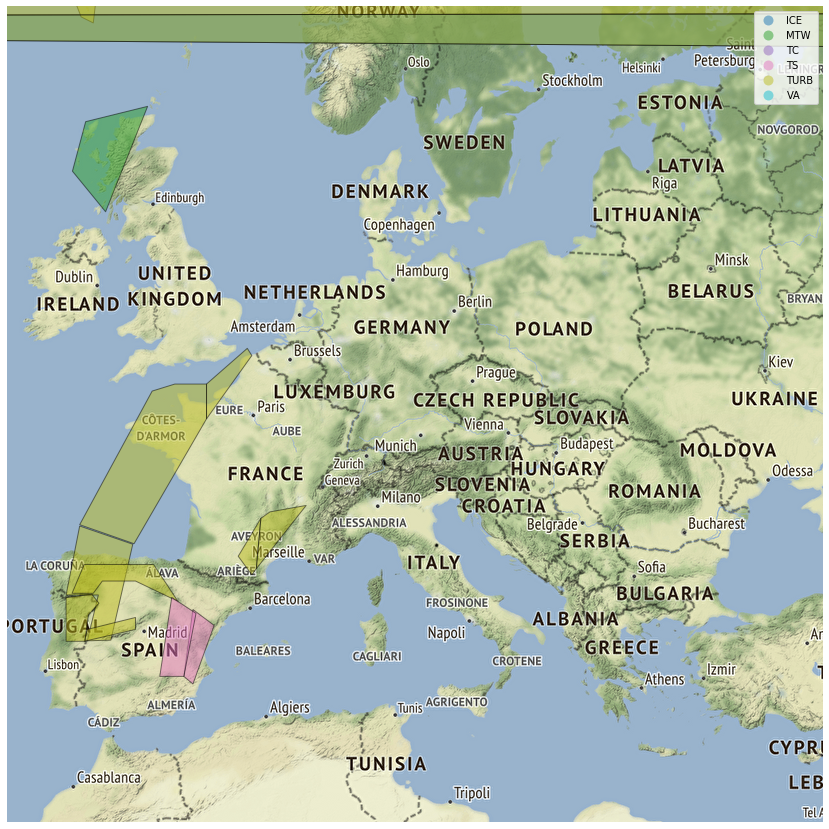

In [8]:
plot(gdf)

#### <br> Filter SIGMETs over France

In [9]:
fr_gdf = gdf[gdf.firId.isin(fr_firId_list)]
print("Nb of SIGMETs over France: ", fr_gdf.shape[0])
fr_gdf.head()

Nb of SIGMETs over France:  4


,icaoId,firId,firName,hazard,validTimeFrom,validTimeTo,qualifier,geom,coords,top,rawSigmet,base,geometry
1,LFPW,LFRR,LFRR BREST,TURB,2020-03-16T08:00:00,2020-03-16T12:00:00,SEV,AREA,"44.000,-4.250,44.750,-7.250,49.750,-3.250,50.0...",33000.0,WSFR35 LFPW 160749\nLFRR SIGMET 2 VALID 160800...,17000.0,"POLYGON ((-4.25000 44.00000, -7.25000 44.75000..."
2,LFPW,LFFF,LFFF PARIS,TURB,2020-03-16T08:00:00,2020-03-16T12:00:00,SEV,AREA,"48.750,-0.250,50.000,-0.250,51.250,2.000,51.00...",33000.0,WSFR31 LFPW 160749\nLFFF SIGMET 1 VALID 160800...,25000.0,"POLYGON ((-0.25000 48.75000, -0.25000 50.00000..."
20,LFPW,LFBB,LFBB BORDEAUX,TURB,2020-03-16T09:00:00,2020-03-16T11:00:00,SEV,AREA,"42.750,2.250,43.500,1.500,45.000,2.750,43.000,...",6000.0,WSFR32 LFPW 160844\nLFBB SIGMET 2 VALID 160900...,0.0,"POLYGON ((2.25000 42.75000, 1.50000 43.50000, ..."
21,LFPW,LFMM,LFMM MARSEILLE,TURB,2020-03-16T09:00:00,2020-03-16T11:00:00,SEV,AREA,"43.000,2.500,45.000,2.750,45.250,3.250,45.500,...",6000.0,WSFR34 LFPW 160844\nLFMM SIGMET 2 VALID 160900...,0.0,"POLYGON ((2.50000 43.00000, 2.75000 45.00000, ..."


#### <br> Load ATC sectors as json polygons (see my atc-sectors-analysis repository to generate such file with SIA open data)

In [10]:
es_gdf = gpd.read_file("volumes.geojson")
es_gdf.sample(2)

,volume,elementary_sector,acc,level_min,level_max,geometry
57,MI,MI,LFRR,345,365,"POLYGON ((0.09600 50.13800, 0.77000 50.40100, ..."
166,TB 2,TB,LFFF,195,265,"POLYGON ((1.46700 51.00000, 2.00000 51.11700, ..."


#### <br> Test intersection of volumes with SIGMETs

In [11]:
ss_map = {}
for index, row in es_gdf.iterrows():
    ss_map[row["volume"]] = False
    for poly in list(fr_gdf.geometry.unique()):
        if row["geometry"].intersects(poly):
            ss_map[row["volume"]] = True
            continue
es_gdf["sigmet"] = es_gdf["volume"].map(ss_map)
es_gdf.head(3)

,volume,elementary_sector,acc,level_min,level_max,geometry,sigmet
0,BN,BN,LFBB,0,195,"POLYGON ((-1.66000 45.98100, -0.94200 46.21300...",False
1,H1,H1,LFBB,195,295,"POLYGON ((1.47200 43.91900, 2.62500 44.51700, ...",True
2,H2,H2,LFBB,295,345,"POLYGON ((1.47200 43.91900, 2.62500 44.51700, ...",True


#### <br> Plot ATC sectors impacted by SIGMETs

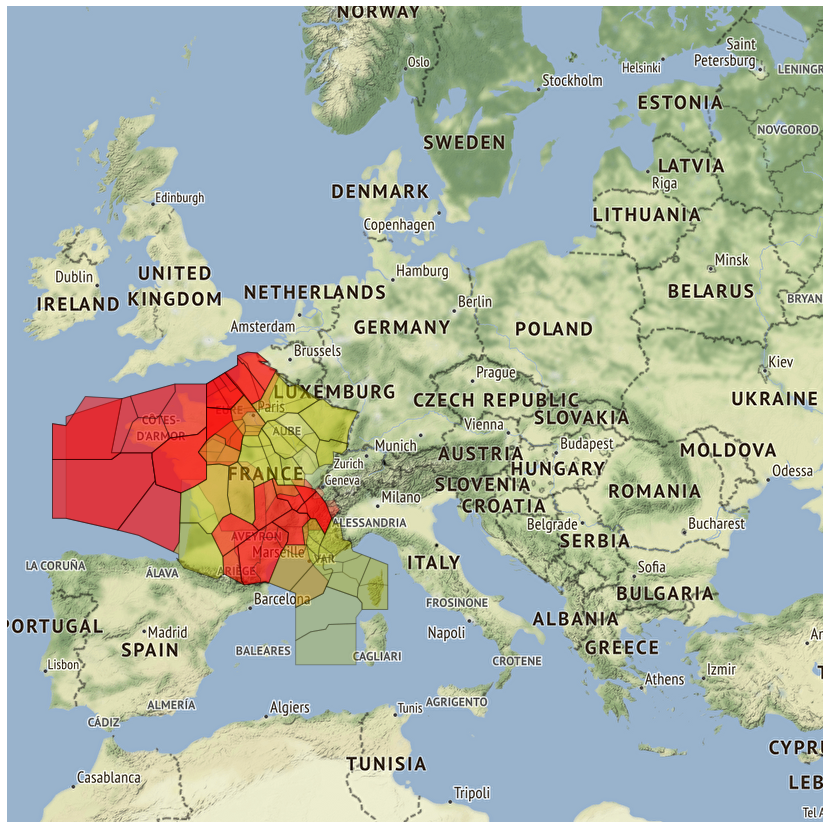

In [12]:
es_gdf_3857 = es_gdf.to_crs(epsg=3857)  # Web mercator
f, ax = plt.subplots(figsize=(15, 15))
ax.imshow(bck, extent=ext, interpolation="sinc", aspect="equal")
es_gdf_3857[es_gdf_3857.sigmet == True].plot(ax=ax, alpha=0.2, color="r", edgecolor="k")
es_gdf_3857[es_gdf_3857.sigmet == False].plot(
    ax=ax, alpha=0.1, color="y", edgecolor="k"
)
ax.set_xlim([ext[0], ext[2]])
ax.set_ylim([ext[1], ext[3]])
ax.set_axis_off()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.savefig("sectors.png", bbox_inches="tight", pad_inches=-0.1)